In [1]:
# !pip install tensorflow==2.3.0

### Imports 

In [2]:
%matplotlib inline
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import boto3

In [3]:
print(f'Using TensorFlow version: {tf.__version__}')

Using TensorFlow version: 2.3.0


#### Seed for Reproducibility

In [4]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Essentials 

In [5]:
s3 = boto3.resource('s3')

TRAIN_DIR = './DATA/CIFAR_10/train'
VALIDATION_DIR = './DATA/CIFAR_10/validation'
TEST_DIR = './DATA/CIFAR_10/test'

### Load Data

In [6]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
X_train.shape

(50000, 32, 32, 3)

In [8]:
y_train.shape

(50000, 1)

In [9]:
X_test.shape

(10000, 32, 32, 3)

In [10]:
y_test.shape

(10000, 1)

### Explore Data

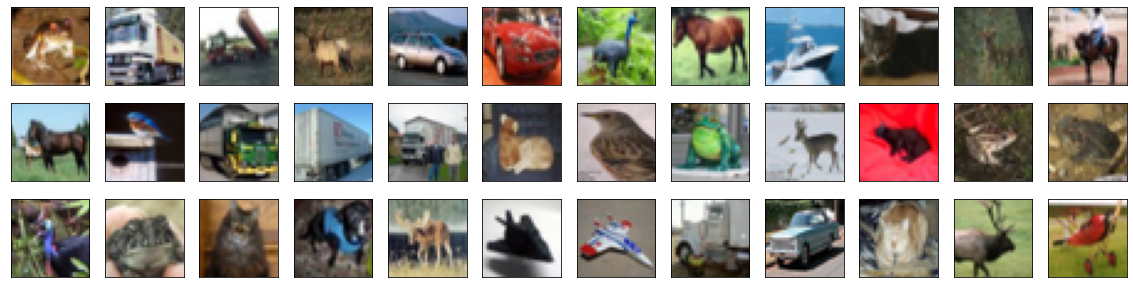

In [11]:
fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

### Prep Data

#### Rescale

In [12]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

#### One Hot Encode Labels

In [13]:
num_classes = len(np.unique(y_train))
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [14]:
np.save(f'{TEST_DIR}/X_test.npy', X_test)
np.save(f'{TEST_DIR}/y_test.npy', y_test)

### Split Data 

In [15]:
# break original train set further into train and validation sets
X_train, X_validation = X_train[500:], X_train[:500]
y_train, y_validation = y_train[500:], y_train[:500]

In [16]:
X_train.shape

(49500, 32, 32, 3)

In [17]:
X_validation.shape

(500, 32, 32, 3)

In [18]:
np.save(f'{TRAIN_DIR}/X_train.npy', X_train)
np.save(f'{TRAIN_DIR}/y_train.npy', y_train)

In [19]:
np.save(f'{VALIDATION_DIR}/X_validation.npy', X_validation)
np.save(f'{VALIDATION_DIR}/y_validation.npy', y_validation)

### Data Augmentation

In [20]:
TRAIN_BATCH_SIZE = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_iterator = data_generator.flow(X_train, y_train, batch_size=TRAIN_BATCH_SIZE)

### Define Model Architecture

In [21]:
model = Sequential()
# CONVOLUTIONAL LAYER 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# CONVOLUTIONAL LAYER 1
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# CONVOLUTIONAL LAYER 3
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# FULLY CONNECTED LAYER 
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          8

### Compile Model

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train Model

In [23]:
checkpointer = ModelCheckpoint(filepath='cifar-best-model.hdf5', verbose=1, save_best_only=True)

In [24]:
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = int(X_train.shape[0]/TRAIN_BATCH_SIZE)
history = model.fit(train_iterator,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(X_validation, y_validation), 
                    callbacks=[checkpointer], 
                    verbose=2, 
                    shuffle=True)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.35712, saving model to cifar-best-model.hdf5
1546/1546 - 63s - loss: 1.6323 - accuracy: 0.4195 - val_loss: 1.3571 - val_accuracy: 0.5080
Epoch 2/30

Epoch 00002: val_loss improved from 1.35712 to 1.07907, saving model to cifar-best-model.hdf5
1546/1546 - 65s - loss: 1.3475 - accuracy: 0.5152 - val_loss: 1.0791 - val_accuracy: 0.6020
Epoch 3/30

Epoch 00003: val_loss improved from 1.07907 to 1.00331, saving model to cifar-best-model.hdf5
1546/1546 - 64s - loss: 1.2411 - accuracy: 0.5579 - val_loss: 1.0033 - val_accuracy: 0.6380
Epoch 4/30

Epoch 00004: val_loss improved from 1.00331 to 0.91840, saving model to cifar-best-model.hdf5
1546/1546 - 64s - loss: 1.1584 - accuracy: 0.5881 - val_loss: 0.9184 - val_accuracy: 0.6920
Epoch 5/30

Epoch 00005: val_loss improved from 0.91840 to 0.89078, saving model to cifar-best-model.hdf5
1546/1546 - 64s - loss: 1.1040 - accuracy: 0.6085 - val_loss: 0.8908 - val_accuracy: 0.7120
Epoch 6/30

Ep

### Visualize Training

In [25]:
def plot_training_history(history):          
    hist = pd.DataFrame(history.history)          
    hist['epoch'] = history.epoch          
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Accuracy')          
    plt.plot(hist['epoch'], hist['accuracy'] * 100, label='Train Accuracy')          
    plt.plot(hist['epoch'], hist['val_accuracy'] * 100, label='Validation Accuracy')
    plt.ylim([0, 100])          
    plt.legend()  
    
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Loss')          
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')          
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.ylim([0,2])
    plt.legend()          
    plt.show()

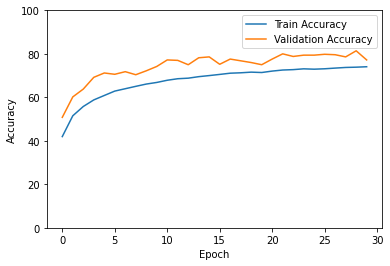

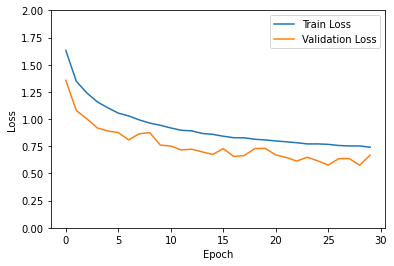

In [26]:
plot_training_history(history)

### Evaluate Model

#### Load the Checkpoint Model

In [27]:
model = load_model('cifar-best-model.hdf5')

In [28]:
result = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {result[1]}')

313/313 [==============================] - 3s 8ms/step - loss: 0.6567 - accuracy: 0.7740
Test Accuracy: 0.7739999890327454


#### Visualize Predictions

In [29]:
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
y_pred = model.predict(X_test)

In [31]:
y_pred[0]

array([0.00369911, 0.00563525, 0.00172861, 0.2565028 , 0.00163426,
       0.6166522 , 0.03755607, 0.00541681, 0.05198042, 0.01919453],
      dtype=float32)

<p>Plot a random sample of test images with their expected (ground truth) and predicted labels.</p>

In [32]:
# pick 32 random image IDs from the total 10000 images 
random_ids = np.random.choice(10000, size=32, replace=False)

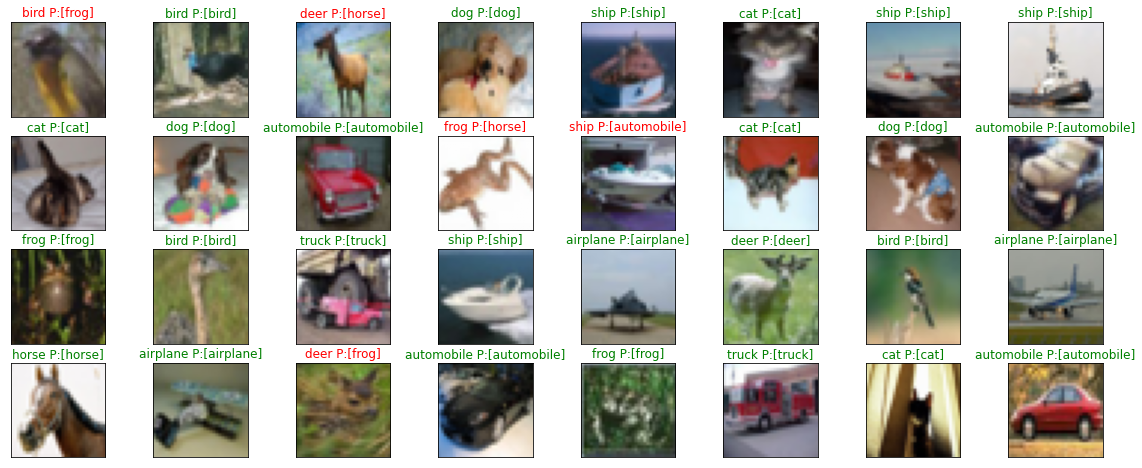

In [33]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(random_ids):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title('{} P:[{}]'.format(CIFAR10_LABELS[true_idx],
                                    CIFAR10_LABELS[pred_idx]),
                                    color=('green' if pred_idx == true_idx else 'red'))

### Real Time Inference

In [34]:
import cv2

#### Save Images for Inference

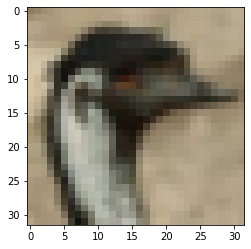

In [71]:
IMAGE_ID = 22
data = X_train[IMAGE_ID, :]
data = np.reshape(data, (32, 32, 3), order='F') # Fortran-like indexing order
plt.imshow(data)

In [72]:
data.shape

(32, 32, 3)

In [73]:
data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
cv2.imwrite('./DATA/CIFAR_10/raw_images/bird.png', data)

True

#### Read an Image

In [74]:
data = cv2.imread('./DATA/CIFAR_10/raw_images/bird.png')
data = data.astype('float32')/255
data = data.reshape(1, 32, 32, 3)
data.shape

(1, 32, 32, 3)

#### Load the best Model

In [75]:
model = load_model('cifar-best-model.hdf5')

#### Run Prediction

In [76]:
y_pred = model.predict([data])

In [77]:
CIFAR10_LABELS[np.argmax(y_pred) - 1]

'bird'